In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import (
    MobileNetV2,
    ResNet50,
    EfficientNetB0,
    InceptionV3,
    DenseNet121
)

from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix


Mounted at /content/drive


In [ ]:
DATASET_DIR = "/content/drive/MyDrive/sorted_waste_dataset"

IMG_SIZE = (128, 128)   # 🔥 biggest speed boost
BATCH_SIZE = 32
EPOCHS = 10             # enough for comparison
NUM_CLASSES = 6


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    DATASET_DIR + "/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

validate_generator = test_datagen.flow_from_directory(
    DATASET_DIR + "/validate",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    DATASET_DIR + "/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 7374 images belonging to 6 classes.
Found 2182 images belonging to 6 classes.
Found 1210 images belonging to 6 classes.


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def fast_transfer(base_model):
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    output = Dense(NUM_CLASSES, activation="softmax")(x)
    return Model(base_model.input, output)


# **MODEL 1: MobileNetV2**

In [ ]:
from tensorflow.keras.applications import MobileNetV2

base = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(128,128,3)
)

model = fast_transfer(base)
model.compile(optimizer=Adam(1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.fit(train_generator,
          validation_data=validate_generator,
          epochs=EPOCHS)


Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 423s 2s/step - accuracy: 0.3013 - loss: 1.8369 - val_accuracy: 0.7351 - val_loss: 0.8792
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 145s 628ms/step - accuracy: 0.6395 - loss: 0.9984 - val_accuracy: 0.8034 - val_loss: 0.6403
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 143s 620ms/step - accuracy: 0.7346 - loss: 0.7532 - val_accuracy: 0.8309 - val_loss: 0.5484
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 143s 618ms/step - accuracy: 0.7757 - loss: 0.6348 - val_accuracy: 0.8566 - val_loss: 0.4666
Epoch 5/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 143s 620ms/step - accuracy: 0.7946 - loss: 0.5852 - val_accuracy: 0.8648 - val_loss: 0.4489
Epoch 6/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 203s 623ms/step - accuracy: 0.8070 - loss: 0.5505 - val_accuracy: 0.8712 - val_loss: 0.4137
Epoch 7/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 143s 619ms/step - accuracy: 0.8339 - loss: 0.4924 - val_accuracy: 0.8731 - val_loss: 0.3964
Epoch 8/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 143s 618ms/step - accuracy: 0.8325 - lo

38/38 ━━━━━━━━━━━━━━━━━━━━ 307s 8s/step
TRANSFER LEARNING MODEL METRICS
Accuracy  : 77.85%
Precision : 0.8361
Recall    : 0.7785
F1 Score  : 0.7931
Z-Score   : 57.11

DETAILED CLASSIFICATION REPORT
                 precision    recall  f1-score   support

biodegradedable       0.77      1.00      0.87        72
      cardboard       0.50      0.92      0.64        60
          glass       0.29      0.94      0.45        36
          metal       0.80      0.77      0.79       170
          paper       0.92      0.79      0.85       523
        plastic       0.85      0.68      0.75       349

       accuracy                           0.78      1210
      macro avg       0.69      0.85      0.73      1210
   weighted avg       0.84      0.78      0.79      1210



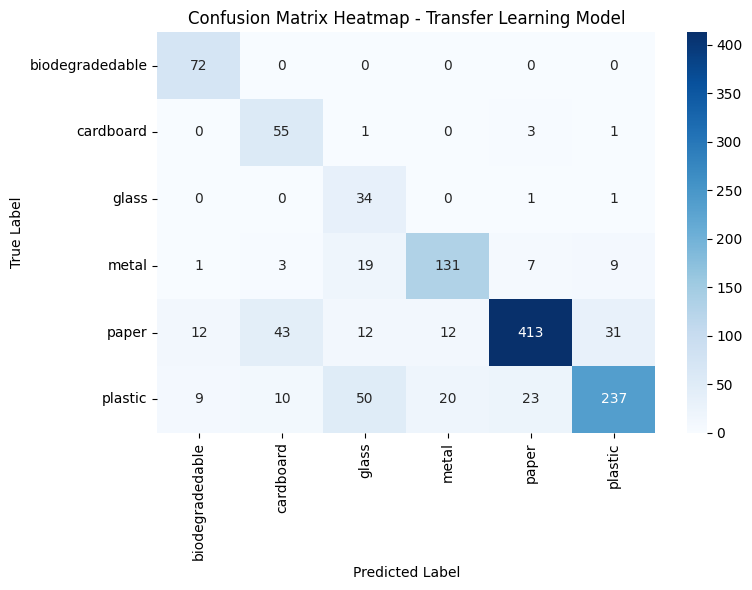

In [ ]:
# =========================================================
# UNIVERSAL EVALUATION BLOCK (TRANSFER LEARNING MODELS)
# =========================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# -------------------------------
# PREDICTIONS
# -------------------------------
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())
num_classes = len(class_names)

# -------------------------------
# METRICS
# -------------------------------
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

print("===================================")
print("TRANSFER LEARNING MODEL METRICS")
print("===================================")
print(f"Accuracy  : {accuracy * 100:.2f}%")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")

# -------------------------------
# Z-SCORE (vs Random Guessing)
# -------------------------------
random_accuracy = 1 / num_classes
std_dev = np.sqrt((random_accuracy * (1 - random_accuracy)) / len(y_true))
z_score = (accuracy - random_accuracy) / std_dev

print(f"Z-Score   : {z_score:.2f}")

# -------------------------------
# CLASSIFICATION REPORT
# -------------------------------
print("\nDETAILED CLASSIFICATION REPORT")
print(classification_report(y_true, y_pred, target_names=class_names))

# -------------------------------
# CONFUSION MATRIX + HEATMAP
# -------------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap - Transfer Learning Model")
plt.tight_layout()
plt.show()


# **MODEL 2: EfficientNetB0t**

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

base = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(128,128,3)
)

model = fast_transfer(base)
model.compile(optimizer=Adam(1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.fit(train_generator,
          validation_data=validate_generator,
          epochs=EPOCHS)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 310s 1s/step - accuracy: 0.2355 - loss: 1.7529 - val_accuracy: 0.3643 - val_loss: 1.6239
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 223s 968ms/step - accuracy: 0.2486 - loss: 1.7511 - val_accuracy: 0.3643 - val_loss: 1.6870
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.2572 - loss: 1.7465 - val_accuracy: 0.3643 - val_loss: 1.6546
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 228s 987ms/step - accuracy: 0.2478 - loss: 1.7488 - val_accuracy: 0.3643 - val_loss: 1.6255
Epoch 5/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 226s 978ms/step - accuracy: 0.2507 - loss: 1.7505 - val_accuracy: 0.3625 - val_loss: 1.6446
Epoch 6/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.2509 - loss: 1.7491 - val_accuracy: 0.3643 - val_loss: 1.6317
Epoch 7/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 225s 976ms/step - accuracy: 0.2549 - loss: 1.7490 - val_accuracy: 0.3643 - val_loss: 1.6198
Epoch 8/10
231/231 ━━━━━━━━━━━━━━━

38/38 ━━━━━━━━━━━━━━━━━━━━ 46s 878ms/step
TRANSFER LEARNING MODEL METRICS
Accuracy  : 2.98%
Precision : 0.0009
Recall    : 0.0298
F1 Score  : 0.0017
Z-Score   : -12.78

DETAILED CLASSIFICATION REPORT
                 precision    recall  f1-score   support

biodegradedable       0.00      0.00      0.00        72
      cardboard       0.00      0.00      0.00        60
          glass       0.03      1.00      0.06        36
          metal       0.00      0.00      0.00       170
          paper       0.00      0.00      0.00       523
        plastic       0.00      0.00      0.00       349

       accuracy                           0.03      1210
      macro avg       0.00      0.17      0.01      1210
   weighted avg       0.00      0.03      0.00      1210



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

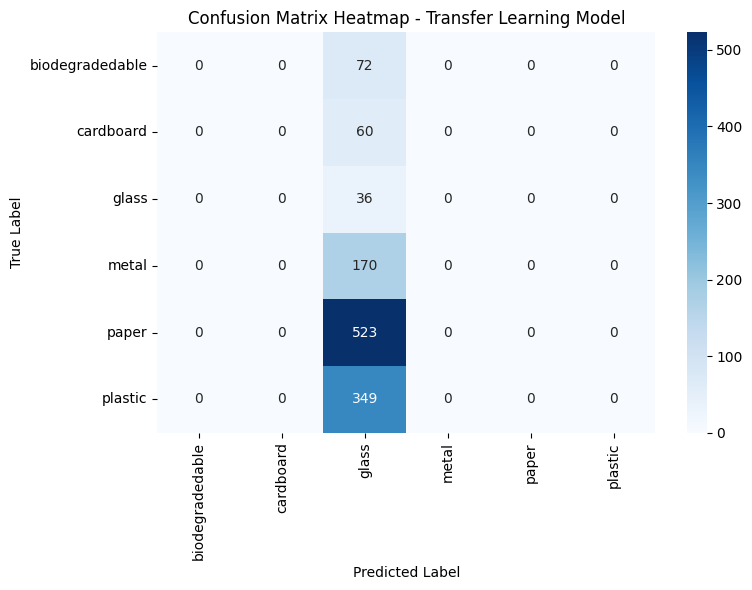

In [ ]:
# =========================================================
# UNIVERSAL EVALUATION BLOCK (TRANSFER LEARNING MODELS)
# =========================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# -------------------------------
# PREDICTIONS
# -------------------------------
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())
num_classes = len(class_names)

# -------------------------------
# METRICS
# -------------------------------
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

print("===================================")
print("TRANSFER LEARNING MODEL METRICS")
print("===================================")
print(f"Accuracy  : {accuracy * 100:.2f}%")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")

# -------------------------------
# Z-SCORE (vs Random Guessing)
# -------------------------------
random_accuracy = 1 / num_classes
std_dev = np.sqrt((random_accuracy * (1 - random_accuracy)) / len(y_true))
z_score = (accuracy - random_accuracy) / std_dev

print(f"Z-Score   : {z_score:.2f}")

# -------------------------------
# CLASSIFICATION REPORT
# -------------------------------
print("\nDETAILED CLASSIFICATION REPORT")
print(classification_report(y_true, y_pred, target_names=class_names))

# -------------------------------
# CONFUSION MATRIX + HEATMAP
# -------------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap - Transfer Learning Model")
plt.tight_layout()
plt.show()


# **MODEL 3: NASNetMobile**

In [ ]:
from tensorflow.keras.applications import NASNetMobile

base = NASNetMobile(
    weights="imagenet",
    include_top=False,
    input_shape=(128,128,3)
)

model = fast_transfer(base)
model.compile(optimizer=Adam(1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.fit(train_generator,
          validation_data=validate_generator,
          epochs=EPOCHS)


19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step - accuracy: 0.3297 - loss: 1.7116 - val_accuracy: 0.7168 - val_loss: 0.8492
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.6376 - loss: 1.0462 - val_accuracy: 0.7965 - val_loss: 0.6281
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.7097 - loss: 0.8634 - val_accuracy: 0.8245 - val_loss: 0.5450
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.7440 - loss: 0.7631 - val_accuracy: 0.8336 - val_loss: 0.4993
Epoch 5/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.7663 - loss: 0.7021 - val_accuracy: 0.8396 - val_loss: 0.4708
Epoch 6/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.7803 - loss: 0.6542 - val_accuracy: 0.8451 - val_loss: 0.4573
Epoch 7/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.7975 - loss: 0.6054 - val_accuracy: 0.8488 - val_loss: 0.4419
Epoch 8/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 323s 1

38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step
TRANSFER LEARNING MODEL METRICS
Accuracy  : 73.80%
Precision : 0.8176
Recall    : 0.7380
F1 Score  : 0.7587
Z-Score   : 53.33

DETAILED CLASSIFICATION REPORT
                 precision    recall  f1-score   support

biodegradedable       0.62      0.90      0.73        72
      cardboard       0.60      0.92      0.73        60
          glass       0.22      0.97      0.36        36
          metal       0.79      0.68      0.73       170
          paper       0.88      0.79      0.83       523
        plastic       0.87      0.60      0.71       349

       accuracy                           0.74      1210
      macro avg       0.67      0.81      0.68      1210
   weighted avg       0.82      0.74      0.76      1210



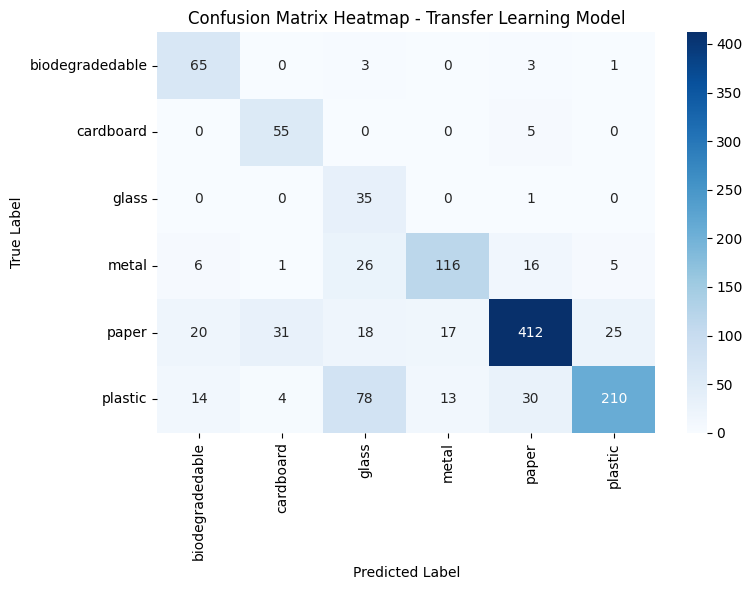

In [ ]:
# =========================================================
# UNIVERSAL EVALUATION BLOCK (TRANSFER LEARNING MODELS)
# =========================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# -------------------------------
# PREDICTIONS
# -------------------------------
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())
num_classes = len(class_names)

# -------------------------------
# METRICS
# -------------------------------
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

print("===================================")
print("TRANSFER LEARNING MODEL METRICS")
print("===================================")
print(f"Accuracy  : {accuracy * 100:.2f}%")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")

# -------------------------------
# Z-SCORE (vs Random Guessing)
# -------------------------------
random_accuracy = 1 / num_classes
std_dev = np.sqrt((random_accuracy * (1 - random_accuracy)) / len(y_true))
z_score = (accuracy - random_accuracy) / std_dev

print(f"Z-Score   : {z_score:.2f}")

# -------------------------------
# CLASSIFICATION REPORT
# -------------------------------
print("\nDETAILED CLASSIFICATION REPORT")
print(classification_report(y_true, y_pred, target_names=class_names))

# -------------------------------
# CONFUSION MATRIX + HEATMAP
# -------------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap - Transfer Learning Model")
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, NASNetMobile
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pandas as pd


In [ ]:
def build_transfer_model(base_model, dense_units, dropout_rate, lr):
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(dense_units, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(NUM_CLASSES, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [ ]:
mobilenet_results = []

learning_rates = [1e-3, 1e-4]
dense_units_list = [128, 256]
dropout_rates = [0.3, 0.5]

for lr in learning_rates:
    for units in dense_units_list:
        for dr in dropout_rates:

            print(f"\nTraining MobileNetV2 | LR={lr}, Units={units}, Dropout={dr}")

            base = MobileNetV2(
                weights="imagenet",
                include_top=False,
                input_shape=(128,128,3)
            )

            model = build_transfer_model(base, units, dr, lr)

            history = model.fit(
                train_generator,
                validation_data=validate_generator,
                epochs=EPOCHS,
                verbose=1
            )

            best_val_acc = max(history.history["val_accuracy"])

            mobilenet_results.append({
                "Model": "MobileNetV2",
                "Learning Rate": lr,
                "Dense Units": units,
                "Dropout": dr,
                "Val Accuracy": best_val_acc
            })



Training MobileNetV2 | LR=0.001, Units=128, Dropout=0.3
Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 163s 684ms/step - accuracy: 0.6723 - loss: 0.9509 - val_accuracy: 0.8767 - val_loss: 0.3682
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 149s 646ms/step - accuracy: 0.8514 - loss: 0.4116 - val_accuracy: 0.8992 - val_loss: 0.3029
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 202s 648ms/step - accuracy: 0.8905 - loss: 0.3020 - val_accuracy: 0.9070 - val_loss: 0.2958
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 151s 655ms/step - accuracy: 0.9141 - loss: 0.2313 - val_accuracy: 0.9088 - val_loss: 0.3015
Epoch 5/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 161s 698ms/step - accuracy: 0.9421 - loss: 0.1683 - val_accuracy: 0.9038 - val_loss: 0.3045
Epoch 6/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 152s 656ms/step - accuracy: 0.9523 - loss: 0.1305 - val_accuracy: 0.9143 - val_loss: 0.2817
Epoch 7/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 152s 659ms/step - accuracy: 0.9643 - loss: 0.1128 - val_accuracy: 0.9134 - val_loss: 0.3098
Epoch 8/10
231/231 

38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 648ms/step
TRANSFER LEARNING MODEL METRICS
Accuracy  : 80.66%
Precision : 0.8640
Recall    : 0.8066
F1 Score  : 0.8196
Z-Score   : 59.73

DETAILED CLASSIFICATION REPORT
                 precision    recall  f1-score   support

biodegradedable       0.81      1.00      0.89        72
      cardboard       0.57      1.00      0.73        60
          glass       0.30      1.00      0.46        36
          metal       0.81      0.86      0.84       170
          paper       0.94      0.82      0.88       523
        plastic       0.89      0.67      0.77       349

       accuracy                           0.81      1210
      macro avg       0.72      0.89      0.76      1210
   weighted avg       0.86      0.81      0.82      1210



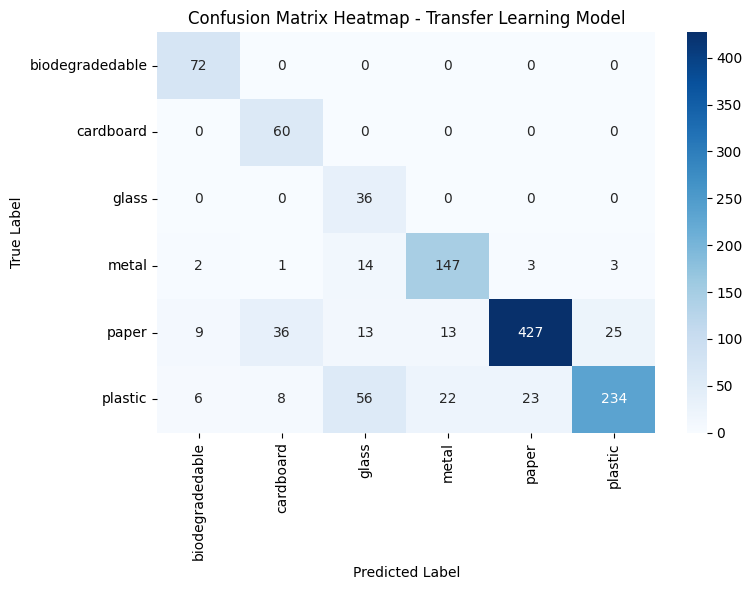

In [ ]:
# =========================================================
# UNIVERSAL EVALUATION BLOCK (TRANSFER LEARNING MODELS)
# =========================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# -------------------------------
# PREDICTIONS
# -------------------------------
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())
num_classes = len(class_names)

# -------------------------------
# METRICS
# -------------------------------
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

print("===================================")
print("TRANSFER LEARNING MODEL METRICS")
print("===================================")
print(f"Accuracy  : {accuracy * 100:.2f}%")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")

# -------------------------------
# Z-SCORE (vs Random Guessing)
# -------------------------------
random_accuracy = 1 / num_classes
std_dev = np.sqrt((random_accuracy * (1 - random_accuracy)) / len(y_true))
z_score = (accuracy - random_accuracy) / std_dev

print(f"Z-Score   : {z_score:.2f}")

# -------------------------------
# CLASSIFICATION REPORT
# -------------------------------
print("\nDETAILED CLASSIFICATION REPORT")
print(classification_report(y_true, y_pred, target_names=class_names))

# -------------------------------
# CONFUSION MATRIX + HEATMAP
# -------------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap - Transfer Learning Model")
plt.tight_layout()
plt.show()


In [ ]:
nasnet_results = []

learning_rates = [1e-4, 5e-5]
dense_units_list = [128]
dropout_rates = [0.4, 0.5]

for lr in learning_rates:
    for units in dense_units_list:
        for dr in dropout_rates:

            print(f"\nTraining NASNetMobile | LR={lr}, Units={units}, Dropout={dr}")

            base = NASNetMobile(
                weights="imagenet",
                include_top=False,
                input_shape=(128,128,3)
            )

            model = build_transfer_model(base, units, dr, lr)

            history = model.fit(
                train_generator,
                validation_data=validate_generator,
                epochs=EPOCHS,
                verbose=1
            )

            best_val_acc = max(history.history["val_accuracy"])

            nasnet_results.append({
                "Model": "NASNetMobile",
                "Learning Rate": lr,
                "Dense Units": units,
                "Dropout": dr,
                "Val Accuracy": best_val_acc
            })



Training NASNetMobile | LR=0.0001, Units=128, Dropout=0.4
Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 308s 1s/step - accuracy: 0.3611 - loss: 1.7045 - val_accuracy: 0.8401 - val_loss: 0.5530
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.6758 - loss: 0.9047 - val_accuracy: 0.8598 - val_loss: 0.4378
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.7243 - loss: 0.7674 - val_accuracy: 0.8584 - val_loss: 0.4194
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.7576 - loss: 0.6723 - val_accuracy: 0.8648 - val_loss: 0.3925
Epoch 5/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.7935 - loss: 0.6032 - val_accuracy: 0.8758 - val_loss: 0.3662
Epoch 6/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.8219 - loss: 0.5589 - val_accuracy: 0.8767 - val_loss: 0.3592
Epoch 7/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.8139 - loss: 0.5320 - val_accuracy: 0.8781 - val_loss: 0.3467
Epoch 8/10
231/231 ━━━━━━━━━━━━━━━━━━━